# Shapes

In [2]:
import cv2
import numpy as np
import os
import pandas as pd
from collections import defaultdict
import re


def calculate_yellow_area(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return cv2.countNonZero(yellow_mask)


def extract_surface_value(filename):
    # Extract the number between underscores
    match = re.search(r"_(\d+)_", filename)
    if match:
        return int(match.group(1))
    return None


def analyze_images(circle_dir, star_dir):
    # Dictionaries to store areas for each target surface
    circle_areas = defaultdict(list)
    star_areas = defaultdict(list)

    # Process circle images
    print("Processing circle images...")
    for filename in os.listdir(circle_dir):
        if filename.endswith(".png"):
            try:
                surface_value = extract_surface_value(filename)
                if surface_value:
                    area = calculate_yellow_area(os.path.join(circle_dir, filename))
                    circle_areas[surface_value].append(area)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    # Process star images
    print("Processing star images...")
    for filename in os.listdir(star_dir):
        if filename.endswith(".png"):
            try:
                surface_value = extract_surface_value(filename)
                if surface_value:
                    area = calculate_yellow_area(os.path.join(star_dir, filename))
                    star_areas[surface_value].append(area)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    # Create summary statistics
    results = []
    all_surfaces = sorted(set(circle_areas.keys()) | set(star_areas.keys()))

    for surface in all_surfaces:
        circle_stats = {
            "mean": np.mean(circle_areas[surface]) if circle_areas[surface] else np.nan,
            "std": np.std(circle_areas[surface]) if circle_areas[surface] else np.nan,
        }
        star_stats = {
            "mean": np.mean(star_areas[surface]) if star_areas[surface] else np.nan,
            "std": np.std(star_areas[surface]) if star_areas[surface] else np.nan,
        }

        results.append(
            {
                "target_surface": surface,
                "circle_mean": circle_stats["mean"],
                "circle_std": circle_stats["std"],
                "star_mean": star_stats["mean"],
                "star_std": star_stats["std"],
                "n_circle_images": len(circle_areas[surface]),
                "n_star_images": len(star_areas[surface]),
            }
        )

    # Create DataFrame
    df = pd.DataFrame(results)
    df = df.sort_values("target_surface")

    return df


# Usage
dir_ = "images/two_shapes3"
circle_dir = f"{dir_}/train/circle" 
star_dir = f"{dir_}/train/star"

try:
    results_df = analyze_images(circle_dir, star_dir)
    # Save to CSV
    results_df.to_csv("shape_analysis_results.csv", index=False)
    print("\nResults have been saved to 'shape_analysis_results.csv'")

except Exception as e:
    print(f"An error occurred: {str(e)}")

Processing circle images...
Processing star images...

Results have been saved to 'shape_analysis_results.csv'


/tmp/ipykernel_15633/3668463154.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_df["circle_ratio"], results_df["star_ratio"]], labels=["Circle", "Star"])


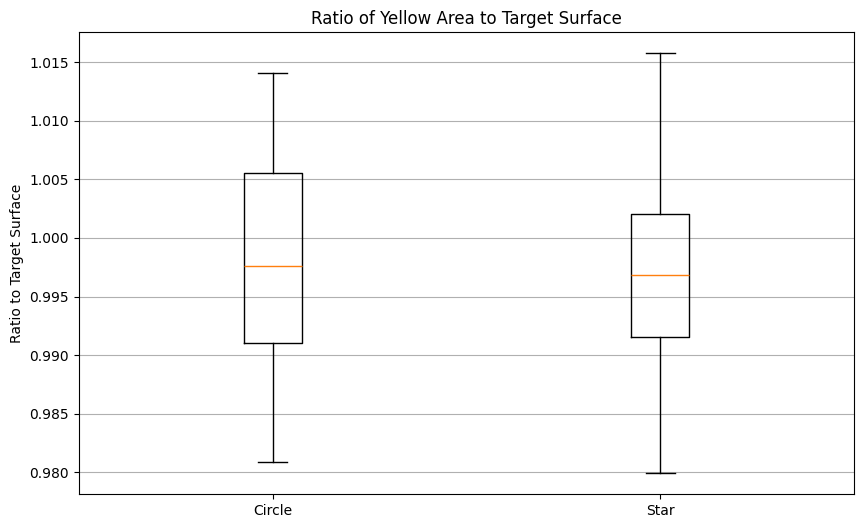

In [34]:
# compute the ratios of circle and star to target areas
results_df["circle_ratio"] = results_df["circle_mean"] / results_df["target_surface"]
results_df["star_ratio"] = results_df["star_mean"] / results_df["target_surface"]
# draw a boxplot of the ratios
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([results_df["circle_ratio"], results_df["star_ratio"]], labels=["Circle", "Star"])
plt.ylabel("Ratio to Target Surface")   
plt.title("Ratio of Yellow Area to Target Surface")
plt.grid(axis="y")
plt.show()

# Points

In [6]:
import cv2
import numpy as np
import os
import pandas as pd
import re


def calculate_color_areas(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    lower_blue = np.array([100, 100, 100])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    return cv2.countNonZero(yellow_mask), cv2.countNonZero(blue_mask)


def extract_info_from_filename(filename):
    values = filename.split("_")
    if len(values) >= 4:
        n_yellow = int(values[1])
        n_blue = int(values[2])
        equalized = "equalized" in filename.lower()
        return n_yellow, n_blue, equalized
    return None, None, False


def analyze_images(image_dir):
    results = []

    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            try:
                full_path = os.path.join(image_dir, filename)
                yellow_area, blue_area = calculate_color_areas(full_path)
                n_yellow, n_blue, equalized = extract_info_from_filename(filename)

                results.append(
                    {
                        "image_name": filename,
                        "yellow_surface": yellow_area,
                        "blue_surface": blue_area,
                        "n_yellow": n_yellow,
                        "n_blue": n_blue,
                        "equalized": equalized,
                    }
                )

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    return pd.DataFrame(results)

In [18]:
yellow = analyze_images("images/one_to_ten/test/yellow")
blue = analyze_images("images/one_to_ten/test/blue")

/tmp/ipykernel_345912/3346841179.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([yellow["yellow_surface"], blue["blue_surface"]], labels=["Yellow", "Blue"])


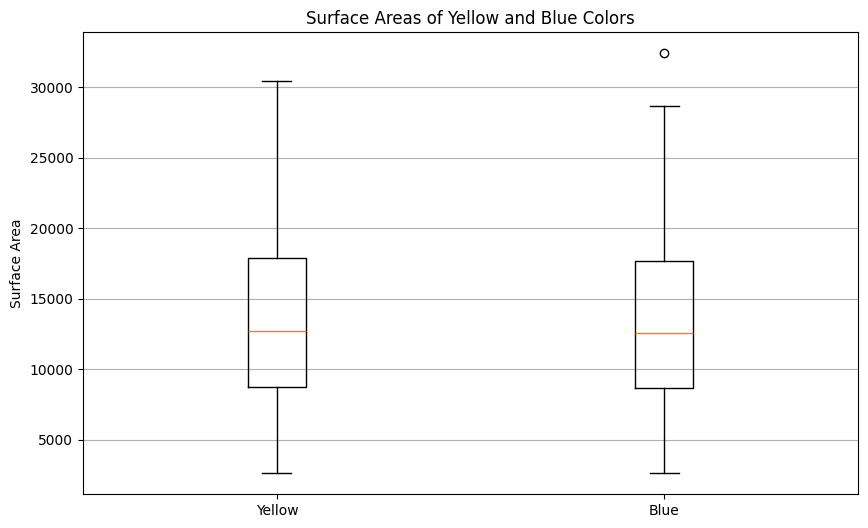

In [19]:
# boxplot of the yellow and blue areas
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([yellow["yellow_surface"], blue["blue_surface"]], labels=["Yellow", "Blue"])
plt.ylabel("Surface Area")
plt.title("Surface Areas of Yellow and Blue Colors")
plt.grid(axis="y")
plt.show()

In [20]:
# table of summary statistics
yellow_stats = yellow["yellow_surface"].describe()
blue_stats = blue["blue_surface"].describe()

pd.DataFrame(
    {
        "Yellow": yellow_stats,
        "Blue": blue_stats,
    }
)


,Yellow,Blue
count,7600.000000,7600.000000
mean,13197.161053,13110.864211
std,5322.697217,5261.946743
min,2626.000000,2626.000000
25%,8728.750000,8639.250000
50%,12694.000000,12582.000000
75%,17869.000000,17681.250000
max,30444.000000,32408.000000


In [15]:
results = pd.read_csv("supplementary_data/one_to_ten_good_run_results.csv")
results["Image"] = results["Image"].str.replace("images/one_to_ten/test/", "")

In [25]:
# add the word "yellow" before the column image_name in yellow
yellow["image_name"] = "yellow/" + yellow["image_name"]
blue["image_name"] = "blue/" + blue["image_name"]

In [26]:
all = pd.concat([yellow, blue], ignore_index=True)
all["image_name"] = all["image_name"].str.replace("v3", "")

In [27]:
# merge the results with the all dataframe
merged = pd.merge(results, all, left_on="Image", right_on="image_name")

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_surface_analysis(df):
    # Filter only equalized images
    equalized_df = df[df["equalized"]]

    # Create scatter plot
    plt.figure(figsize=(10, 6))

    # Plot points with different colors based on correctness
    correct = equalized_df[equalized_df["Is correct"] == 1]
    incorrect = equalized_df[equalized_df["Is correct"] == 0]

    plt.scatter(
        correct["yellow_surface"],
        correct["blue_surface"],
        c="green",
        label="Correct",
        alpha=0.6,
    )
    plt.scatter(
        incorrect["yellow_surface"],
        incorrect["blue_surface"],
        c="red",
        label="Incorrect",
        alpha=0.6,
    )

    plt.xlabel("Yellow Surface Area")
    plt.ylabel("Blue Surface Area")
    plt.title("Surface Areas Distribution for Equalized Images")
    plt.legend()

    # Add diagonal line for reference
    max_val = max(
        equalized_df["yellow_surface"].max(), equalized_df["blue_surface"].max()
    )
    plt.plot([0, max_val], [0, max_val], "k--", alpha=0.3)

    # Additional plot showing distribution of ratios
    plt.figure(figsize=(10, 6))
    equalized_df["surface_ratio"] = (
        equalized_df["yellow_surface"] / equalized_df["blue_surface"]
    )

    sns.boxplot(data=equalized_df, x="Is correct", y="surface_ratio")
    plt.title("Distribution of Yellow/Blue Surface Ratio by Prediction Correctness")
    plt.ylabel("Yellow/Blue Surface Ratio")

    plt.show()

/tmp/ipykernel_345912/1464350139.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equalized_df["surface_ratio"] = (


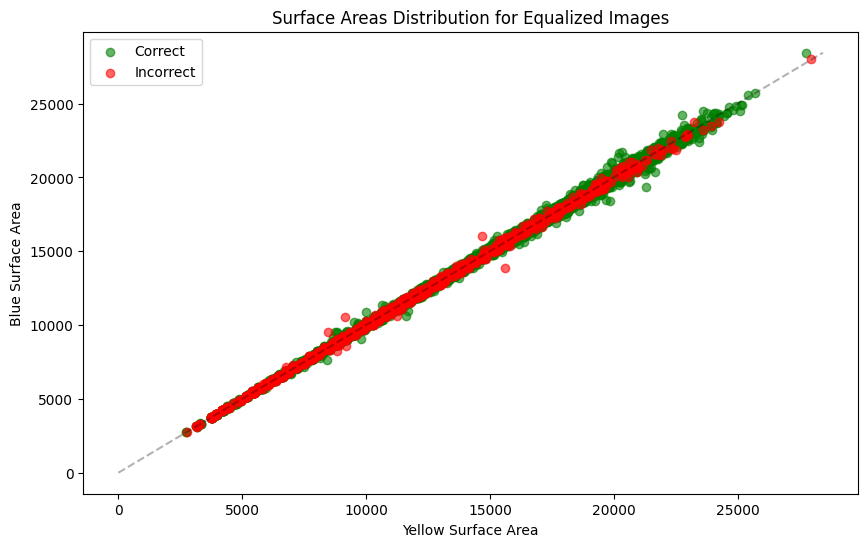

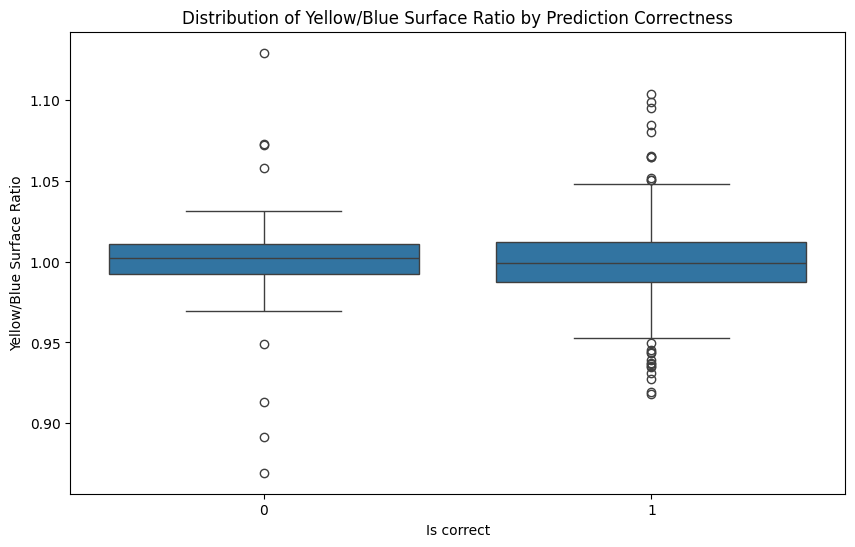

In [31]:
plot_surface_analysis(merged)

In [33]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_surface_bias(df):
    # Filter equalized images
    # in the "Is correct" colums, transform 1 to True and 0 to False
    df["Is correct"] = df["Is correct"].astype(bool)

    eq_df = df[df["equalized"]].copy()

    # Calculate surface ratios and absolute differences
    eq_df["surface_ratio"] = eq_df["yellow_surface"] / eq_df["blue_surface"]
    eq_df["surface_diff"] = np.abs(eq_df["yellow_surface"] - eq_df["blue_surface"])
    eq_df["surface_diff_percent"] = (
        eq_df["surface_diff"]
        / ((eq_df["yellow_surface"] + eq_df["blue_surface"]) / 2)
        * 100
    )

    # Statistical tests
    ratio_ttest = stats.ttest_ind(
        eq_df[eq_df["Is correct"]]["surface_ratio"],
        eq_df[~eq_df["Is correct"]]["surface_ratio"],
    )

    diff_ttest = stats.ttest_ind(
        eq_df[eq_df["Is correct"]]["surface_diff"],
        eq_df[~eq_df["Is correct"]]["surface_diff"],
    )

    # Calculate effect sizes (Cohen's d)
    def cohens_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(group1) - np.mean(group2)) / pooled_se if pooled_se != 0 else 0

    ratio_d = cohens_d(
        eq_df[eq_df["Is correct"]]["surface_ratio"],
        eq_df[~eq_df["Is correct"]]["surface_ratio"],
    )

    diff_d = cohens_d(
        eq_df[eq_df["Is correct"]]["surface_diff"],
        eq_df[~eq_df["Is correct"]]["surface_diff"],
    )

    # Descriptive statistics
    desc_stats = pd.DataFrame(
        {
            "Correct": eq_df[eq_df["Is correct"]]["surface_diff_percent"].describe(),
            "Incorrect": eq_df[~eq_df["Is correct"]]["surface_diff_percent"].describe(),
        }
    )

    # Correlation analysis
    correlation = stats.pointbiserialr(eq_df["Is correct"], eq_df["surface_diff"])

    # Visualizations
    plt.figure(figsize=(12, 4))

    # Surface difference distribution
    plt.subplot(121)
    sns.boxplot(data=eq_df, x="Is correct", y="surface_diff_percent")
    plt.title("Surface Area Differences by Prediction")
    plt.ylabel("Absolute Difference (%)")

    # Success rate by difference quartiles
    eq_df["diff_quartile"] = pd.qcut(
        eq_df["surface_diff"], q=4, labels=["Q1", "Q2", "Q3", "Q4"]
    )
    success_by_quartile = eq_df.groupby("diff_quartile")["Is correct"].mean()

    plt.subplot(122)
    success_by_quartile.plot(kind="bar")
    plt.title("Success Rate by Surface Difference Quartile")
    plt.ylabel("Success Rate")

    plt.tight_layout()
    plt.show()

    # Print report
    print("\nSURFACE AREA BIAS ANALYSIS REPORT")
    print("=" * 50)
    print("\n1. Basic Statistics")
    print(f"Total equalized images analyzed: {len(eq_df)}")
    print(f"Overall success rate: {(eq_df['Is correct'].mean()*100):.1f}%")

    print("\n2. Surface Differences Analysis")
    print(
        f"Mean difference (%) for correct predictions: {eq_df[eq_df['Is correct']]['surface_diff_percent'].mean():.1f}%"
    )
    print(
        f"Mean difference (%) for incorrect predictions: {eq_df[~eq_df['Is correct']]['surface_diff_percent'].mean():.1f}%"
    )

    print("\n3. Statistical Tests")
    print(
        f"Surface ratio t-test: t={ratio_ttest.statistic:.3f}, p={ratio_ttest.pvalue:.3f}"
    )
    print(
        f"Surface difference t-test: t={diff_ttest.statistic:.3f}, p={diff_ttest.pvalue:.3f}"
    )
    print(f"Effect size (Cohen's d) for ratios: {ratio_d:.3f}")
    print(f"Effect size (Cohen's d) for differences: {diff_d:.3f}")

    print("\n4. Correlation Analysis")
    print(
        f"Point-biserial correlation: r={correlation.correlation:.3f}, p={correlation.pvalue:.3f}"
    )

    print("\n5. Success Rate by Surface Difference Quartile")
    print(success_by_quartile)

    # Return key statistics for further analysis if needed
    return {
        "total_images": len(eq_df),
        "success_rate": eq_df["Is correct"].mean(),
        "ratio_ttest": ratio_ttest,
        "diff_ttest": diff_ttest,
        "correlation": correlation,
        "success_by_quartile": success_by_quartile,
    }

/tmp/ipykernel_345912/449665917.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_quartile = eq_df.groupby("diff_quartile")["Is correct"].mean()


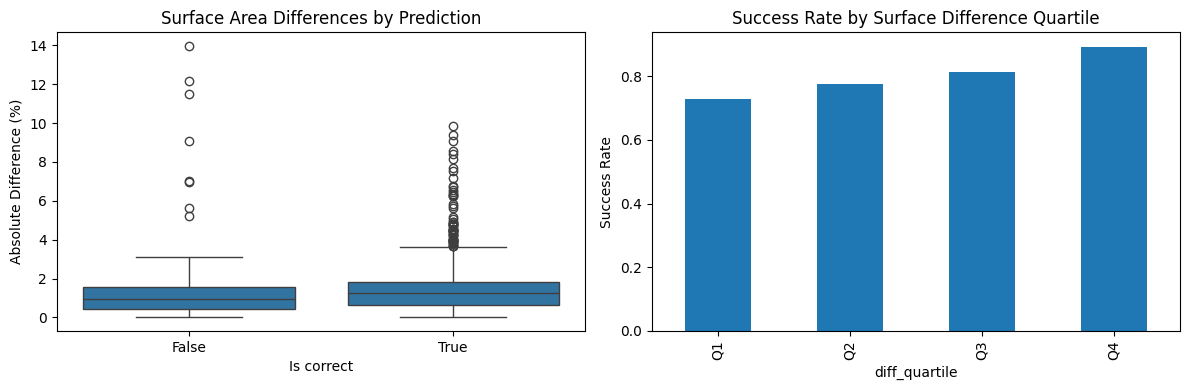


SURFACE AREA BIAS ANALYSIS REPORT

1. Basic Statistics
Total equalized images analyzed: 3800
Overall success rate: 80.2%

2. Surface Differences Analysis
Mean difference (%) for correct predictions: 1.3%
Mean difference (%) for incorrect predictions: 1.1%

3. Statistical Tests
Surface ratio t-test: t=-2.310, p=0.021
Surface difference t-test: t=8.070, p=0.000
Effect size (Cohen's d) for ratios: -0.094
Effect size (Cohen's d) for differences: 0.329

4. Correlation Analysis
Point-biserial correlation: r=0.130, p=0.000

5. Success Rate by Surface Difference Quartile
diff_quartile
Q1    0.727655
Q2    0.776971
Q3    0.812166
Q4    0.893460
Name: Is correct, dtype: float64


{'total_images': 3800,
 'success_rate': 0.8023684210526316,
 'ratio_ttest': TtestResult(statistic=-2.3103759984459726, pvalue=0.020920683001609642, df=3798.0),
 'diff_ttest': TtestResult(statistic=8.069540209110633, pvalue=9.377666895735464e-16, df=3798.0),
 'correlation': SignificanceResult(statistic=0.12983142750770282, pvalue=9.37766689573458e-16),
 'success_by_quartile': diff_quartile
 Q1    0.727655
 Q2    0.776971
 Q3    0.812166
 Q4    0.893460
 Name: Is correct, dtype: float64}

In [34]:
analyze_surface_bias(merged)